
=== Baseline: K=1 ===
Accuracy: 0.47421031587365053
F1_macro: 0.17506181493129175

=== Optimized Model ===
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Cross-val best score: 0.4683628421207
Test Accuracy: 0.468812475009996
F1_macro: 0.1571423138171703

=== Summary ===
       Model  Accuracy  F1_macro
0        K=1  0.474210  0.175062
1  Optimized  0.468812  0.157142

=== Per-class Recall ===
           K=1  Optimized
Class 0  0.545      0.536
Class 1  0.463      0.459
Class 2  0.052      0.065
Class 3  0.040      0.040
Class 4  0.045      0.045
Class 5  0.333      0.333
Class 6  0.000      0.000
Class 7  0.000      0.000
Class 8  0.000      0.000
Class 9  0.000      0.000


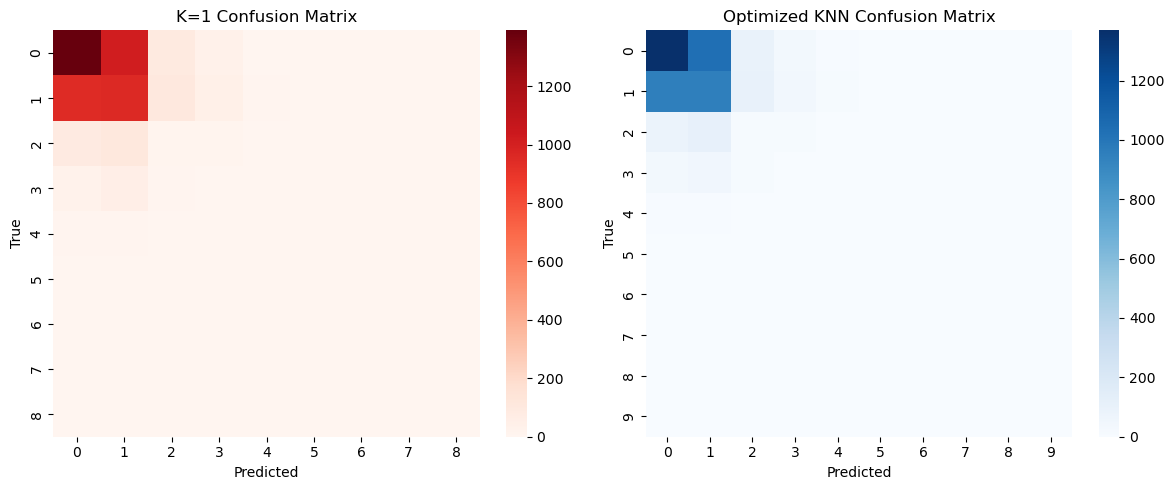

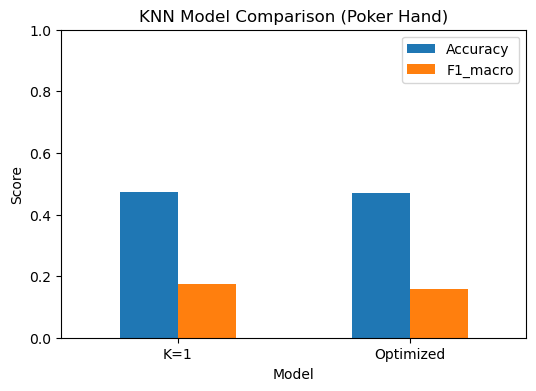

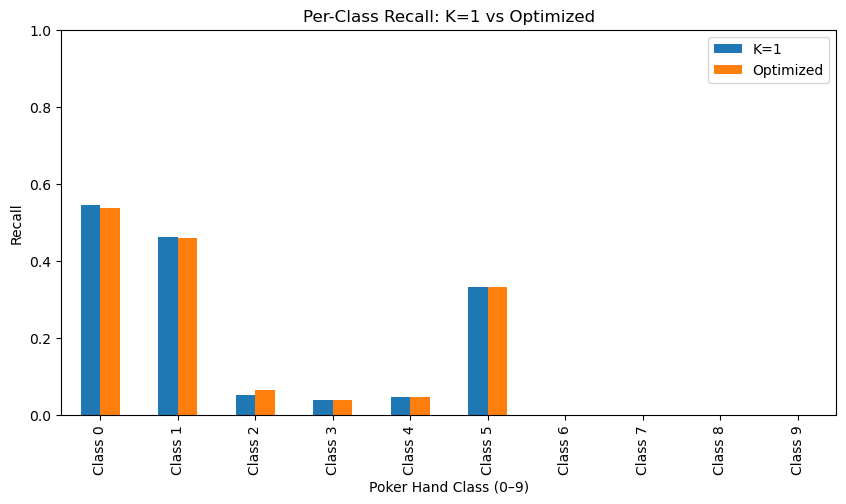

In [4]:
# ============================================================
# Poker Hand KNN Comparison: K=1 vs Optimized (GridSearch + ROS)
# ============================================================

import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣ Load and split data
# ------------------------------------------------------------
cols = ['S1','R1','S2','R2','S3','R3','S4','R4','S5','R5','ORD']
# poker = pd.read_csv('poker-hand-training-true.data', header=None, names=cols)
poker = pd.read_csv('poker-hand-training-true.data', skiprows=1, header=None, names=cols)


X = poker[cols[:-1]]
y = poker['ORD']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 2️⃣ Baseline Model: K = 1
# ------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

knn_k1 = KNeighborsClassifier(n_neighbors=1)
knn_k1.fit(X_train_scaled, y_train)
y_pred_k1 = knn_k1.predict(X_test_scaled)

print("\n=== Baseline: K=1 ===")
print("Accuracy:", accuracy_score(y_test, y_pred_k1))
print("F1_macro:", f1_score(y_test, y_pred_k1, average='macro'))

# ------------------------------------------------------------
# 3️⃣ Optimized Model: GridSearchCV + RandomOverSampler
# ------------------------------------------------------------
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_opt = best_model.predict(X_test)

print("\n=== Optimized Model ===")
print("Best parameters:", grid.best_params_)
print("Cross-val best score:", grid.best_score_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_opt))
print("F1_macro:", f1_score(y_test, y_pred_opt, average='macro'))

# ------------------------------------------------------------
# 4️⃣ Summary Table
# ------------------------------------------------------------
metrics = pd.DataFrame({
    "Model": ["K=1", "Optimized"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_k1),
        accuracy_score(y_test, y_pred_opt)
    ],
    "F1_macro": [
        f1_score(y_test, y_pred_k1, average='macro'),
        f1_score(y_test, y_pred_opt, average='macro')
    ]
})
print("\n=== Summary ===")
print(metrics)

# ------------------------------------------------------------
# 5️⃣ Per-Class Recall Comparison
# ------------------------------------------------------------
# ------------------------------------------------------------
# Safe per-class recall comparison 
# ------------------------------------------------------------

# Define all possible poker hand classes (0–9)
all_classes = list(range(10))

# Build dataframe safely, using 0 recall for missing labels
recall_data = {
    "K=1": [
        report_k1[str(i)]["recall"] if str(i) in report_k1 else 0.0
        for i in all_classes
    ],
    "Optimized": [
        report_opt[str(i)]["recall"] if str(i) in report_opt else 0.0
        for i in all_classes
    ],
}

# Create DataFrame with clear labels
recall_df = pd.DataFrame(recall_data, index=[f"Class {i}" for i in all_classes])

print("\n=== Per-class Recall ===")
print(recall_df.round(3))


# ------------------------------------------------------------
# 6️⃣ Visualization — Confusion Matrices
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_k1), cmap="Reds", ax=axes[0])
sns.heatmap(confusion_matrix(y_test, y_pred_opt), cmap="Blues", ax=axes[1])
axes[0].set_title("K=1 Confusion Matrix")
axes[1].set_title("Optimized KNN Confusion Matrix")
for ax in axes:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7️⃣ Visualization — Accuracy & F1 Comparison
# ------------------------------------------------------------
metrics.plot(
    x="Model", y=["Accuracy", "F1_macro"], kind="bar",
    rot=0, ylim=(0,1), figsize=(6,4),
    title="KNN Model Comparison (Poker Hand)"
)
plt.ylabel("Score")
plt.show()

# ------------------------------------------------------------
# 8️⃣ Visualization — Per-Class Recall Bar Chart
# ------------------------------------------------------------
recall_df.plot(kind='bar', figsize=(10,5), ylim=(0,1),
               title="Per-Class Recall: K=1 vs Optimized")
plt.ylabel("Recall")
plt.xlabel("Poker Hand Class (0–9)")
plt.legend()
plt.show()
